In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython import display

import functools

import collections
import random
import os
import requests
import zipfile
import hashlib
import time

import jax
import jax.numpy as jnp
import numpy as np
from jax import random

jax.config.update("jax_enable_x64", True)

try:
    from flax import linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn
from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

key = random.PRNGKey(314)

# Layers

## Positionwise Feed-Forward Networks

In [2]:
class PositionWiseFFN(nn.Module):
    ffn_num_input: int
    ffn_num_hiddens: int
    ffn_num_outputs: int

    def setup(self):
        self.dense1 = nn.Dense(self.ffn_num_hiddens)
        self.relu = nn.relu
        self.dense2 = nn.Dense(self.ffn_num_outputs)

    def __call__(self, inputs):
        return self.dense2(self.relu(self.dense1(inputs)))

In [3]:
ffn = PositionWiseFFN(ffn_num_input=4, ffn_num_hiddens=4, ffn_num_outputs=8)

x = jnp.ones((2, 3, 4))
key, mykey = random.split(key, 2)
params = ffn.init(mykey, x)
Y = ffn.apply(params, x)

print(Y.shape)

(2, 3, 8)


## Residual Connection and Layer Normalization

In [4]:
class AddNorm(nn.Module):
    dropout_rate: int

    def setup(self):
        self.dropout = nn.Dropout(self.dropout_rate)
        self.ln = nn.LayerNorm()

    def __call__(self, X, Y, train):
        return self.ln(self.dropout(Y, deterministic=not train) + X)

In [5]:
add_norm = AddNorm(0.5)  # Normalized_shape is input.size()[1:]
key, mykey = random.split(key, 2)
x = jnp.ones((2, 3, 4))
y = jnp.ones((2, 3, 4))
params = add_norm.init(mykey, x, y, False)
add_norm.apply(params, x, y, False).shape

(2, 3, 4)

# Encoder

In [6]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    dropout_rate: float

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    @nn.compact
    def __call__(self, queries, keys, values, train, valid_lens=None):
        d = queries.shape[-1]
        scores = queries @ (keys.swapaxes(1, 2)) / math.sqrt(d)
        attention_weights = masked_softmax(scores, valid_lens)
        dropout_layer = nn.Dropout(self.dropout_rate, deterministic=not train)
        return dropout_layer(attention_weights) @ values, attention_weights

In [7]:
class MultiHeadAttention(nn.Module):
    num_hiddens: int
    num_heads: int
    dropout: float
    bias: bool = False

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens, train):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias)(queries), self.num_heads)
        keys = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias)(keys), self.num_heads)
        values = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias)(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = jnp.repeat(valid_lens, self.num_heads, axis=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output, attention_weights = DotProductAttention(self.dropout)(queries, keys, values, train, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return nn.Dense(self.num_hiddens, use_bias=self.bias)(output_concat), attention_weights

In [8]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen), dtype=jnp.float32)[None, :] < valid_len[:, None]

    X = jnp.where(~mask, value, X)

    return X


def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.softmax(X.reshape(shape), axis=-1)


def transpose_qkv(X, num_heads):
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape((X.shape[0], X.shape[1], num_heads, -1))

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = jnp.transpose(X, (0, 2, 1, 3))

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape((-1, X.shape[2], X.shape[3]))


def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`"""
    X = X.reshape((-1, num_heads, X.shape[1], X.shape[2]))
    X = jnp.transpose(X, (0, 2, 1, 3))
    return X.reshape((X.shape[0], X.shape[1], -1))

In [9]:
class PositionalEncoding(nn.Module):
    num_hiddens: int
    dropout: float
    max_len = 1000

    @nn.compact
    def __call__(self, X, train):
        dropout = nn.Dropout(self.dropout)
        P = jax.numpy.zeros((1, self.max_len, self.num_hiddens))
        x = jax.numpy.arange(self.max_len, dtype=jax.numpy.float32).reshape(-1, 1) / jax.numpy.power(
            10000, jax.numpy.arange(0, self.num_hiddens, 2, dtype=jax.numpy.float32) / self.num_hiddens
        )
        P = P.at[:, :, 0::2].set(jax.numpy.sin(x))
        P = P.at[:, :, 1::2].set(jax.numpy.cos(x))

        X = X + P[:, : X.shape[1], :]
        return dropout(X, deterministic=not train), P

In [10]:
class EncoderBlock(nn.Module):
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    dropout_rate: float
    use_bias: bool = False

    def setup(self):
        self.attention = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout_rate, self.use_bias)
        self.addnorm1 = AddNorm(self.dropout_rate)
        self.ffn = PositionWiseFFN(self.ffn_num_input, self.ffn_num_hiddens, self.num_hiddens)
        self.addnorm2 = AddNorm(self.dropout_rate)

    def __call__(self, X, valid_lens, train):
        output, attention_weights = self.attention(X, X, X, valid_lens, train)
        Y = self.addnorm1(X, output, train)
        return self.addnorm2(Y, self.ffn(Y), train), attention_weights

In [11]:
X = jnp.ones((2, 100, 24))
valid_lens = jnp.array([3, 2])
encoder_blk = EncoderBlock(24, 24, 48, 8, 0.5)
key, mykey = random.split(key, 2)
params = encoder_blk.init(mykey, X, valid_lens, False)
encoder_blk_output = encoder_blk.apply(params, X, valid_lens, False)[0]
encoder_blk_output.shape

(2, 100, 24)

In [12]:
class TransformerEncoder(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout_rate: float
    use_bias: bool = False

    def setup(self):
        self.embedding = nn.Embed(self.vocab_size, self.num_hiddens)
        self.pos_encoding = PositionalEncoding(self.num_hiddens, self.dropout_rate)
        self.blks = [
            EncoderBlock(
                self.num_hiddens,
                self.ffn_num_input,
                self.ffn_num_hiddens,
                self.num_heads,
                self.dropout_rate,
                self.use_bias,
            )
            for _ in range(self.num_layers)
        ]

    def __call__(self, X, valid_lens, train):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X, _ = self.pos_encoding(self.embedding(X) * jnp.sqrt(self.num_hiddens), train)

        attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X, attention_weight = blk(X, valid_lens, train)
            attention_weights[i] = attention_weight
        return X, attention_weights

The shape of the transformer encoder output is (batch size, number of time steps, num_hiddens).

In [13]:
encoder_test = TransformerEncoder(200, 24, 24, 48, 8, 2, 0.5)
key, mykey = random.split(key, 2)
x = jnp.ones((2, 100), jnp.int64)
valid_lens = jnp.array([3, 2])
params = encoder_test.init(mykey, x, valid_lens, False)
encoder_test.apply(params, x, valid_lens, False)[0].shape

(2, 100, 24)

# Decoder

In [14]:
class DecoderBlock(nn.Module):
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    dropout_rate: float
    i: int

    # The `i`-th block in the decoder
    def setup(self):
        self.attention1 = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout_rate)
        self.addnorm1 = AddNorm(self.dropout_rate)
        self.attention2 = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout_rate)
        self.addnorm2 = AddNorm(self.dropout_rate)
        self.ffn = PositionWiseFFN(self.ffn_num_input, self.ffn_num_hiddens, self.num_hiddens)
        self.addnorm3 = AddNorm(self.dropout_rate)

    def __call__(self, X, state, train):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = jnp.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values

        if train:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = jnp.tile(jnp.arange(1, num_steps + 1), (batch_size, 1))
        else:
            dec_valid_lens = None

        # Self-attention
        X2, attention_weight1 = self.attention1(X, key_values, key_values, dec_valid_lens, train)
        Y = self.addnorm1(X, X2, train)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2, attention_weight2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, train)
        Z = self.addnorm2(Y, Y2, train)
        return self.addnorm3(Z, self.ffn(Z), train), state, attention_weight1, attention_weight2

In [15]:
decoder_blk = DecoderBlock(24, 24, 48, 8, 0.5, 0)
key, mykey = random.split(key, 2)
X = jnp.ones((2, 100, 24))
state = [encoder_blk_output, valid_lens, [None]]
train = False
params = decoder_blk.init(mykey, X, state, train)
decoder_blk.apply(params, X, state, train)[0].shape

(2, 100, 24)

In [16]:
class TransformerDecoder(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout_rate: float

    def setup(self):
        self.embedding = nn.Embed(self.vocab_size, self.num_hiddens)
        self.pos_encoding = PositionalEncoding(self.num_hiddens, self.dropout_rate)
        self.blks = [
            DecoderBlock(
                self.num_hiddens, self.ffn_num_input, self.ffn_num_hiddens, self.num_heads, self.dropout_rate, i
            )
            for i in range(self.num_layers)
        ]
        self.dense = nn.Dense(self.vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def __call__(self, X, state, train):
        X, _ = self.pos_encoding(self.embedding(X) * jnp.sqrt(self.num_hiddens), train)
        attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state, attention_weight1, attention_weight2 = blk(X, state, train)
            # Decoder self-attention weights
            attention_weights[0][i] = attention_weight1
            # Encoder-decoder attention weights
            attention_weights[1][i] = attention_weight2
        return self.dense(X), state, attention_weights

# Transformer

In [17]:
class EncoderDecoder(nn.Module):
    encoder: nn.Module
    decoder: nn.Module

    def __call__(self, enc_X, valid_lens, dec_X, train):
        enc_outputs, attention_weights = self.encoder(enc_X, valid_lens, train)
        dec_state = self.decoder.init_state(enc_outputs, valid_lens)
        return (*self.decoder(dec_X, dec_state, train), attention_weights)

    def encode(self, enc_X, valid_lens, train):
        return self.encoder(enc_X, valid_lens, train)

    def decode(self, dec_X, dec_state, train):
        return self.decoder(dec_X, dec_state, train)

# Full model


In [18]:
# Required functions for downloading data
try:
    from torch.utils import data
except ModuleNotFoundError:
    %pip install -qq torch
    from torch.utils import data
import torch


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [19]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract("fra-eng")
    with open(os.path.join(data_dir, "fra.txt"), "r") as f:
        return f.read()


def preprocess_nmt(text):
    """Preprocess the English-French dataset."""

    def no_space(char, prev_char):
        return char in set(",.!?") and prev_char != " "

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace("\u202f", " ").replace("\xa0", " ").lower()
    # Insert space between words and punctuation marks
    out = [" " + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return "".join(out)


def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split("\n")):
        if num_examples and i > num_examples:
            break
        parts = line.split("\t")
        if len(parts) == 2:
            source.append(parts[0].split(" "))
            target.append(parts[1].split(" "))
    return source, target

In [20]:
class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [21]:
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)


def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab["<eos>"]] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab["<pad>"]) for l in lines])
    valid_len = reduce_sum(astype(array != vocab["<pad>"], torch.int32), 1)
    return array, valid_len

In [22]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))


def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

# Data

We use a english-french dataset. See [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb#scrollTo=yDmK1xQ9T4IY) for details.

In [23]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["fra-eng"] = (DATA_URL + "fra-eng.zip", "94646ad1522d915e7b0f9296181140edcf86a4f5")

batch_size, num_steps = 64, 10

In [24]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [25]:
num_hiddens, num_layers, dropout = 32, 2, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout
)
decoder = TransformerDecoder(
    len(tgt_vocab), num_hiddens, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout
)
Transformer = functools.partial(EncoderDecoder, encoder, decoder)

# Training

In [26]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [27]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

In [28]:
def cross_entropy_loss(logits, labels, lengths) -> float:
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    one_hot_labels = jax.nn.one_hot(labels, num_classes=logits.shape[2])
    xe = jnp.sum(nn.log_softmax(logits) * one_hot_labels, axis=-1)
    masked_xe = jnp.mean(sequence_mask(xe, lengths))
    return -masked_xe

In [29]:
p = jnp.array([[[0.10, 0.40, 0.50]]])
label = jnp.array([[1]])
valid_len = jnp.array([1])
cross_entropy_loss(p, label, valid_len)

Array(1.04591068, dtype=float64)

In [30]:
def get_initial_params(model, rng):
    """Returns the initial parameters of a seq2seq model."""
    valid_lens = jnp.ones((64), jnp.int64)
    init_rngs = {"params": random.PRNGKey(0), "dropout": random.PRNGKey(1)}
    variables = model.init(
        init_rngs, jnp.ones((64, 10), jnp.int64), valid_lens, jnp.ones((64, 10), jnp.int64), train=False
    )
    return variables["params"]


def get_train_state(rng, lr) -> train_state.TrainState:
    """Returns a train state."""
    model = Transformer()
    params = get_initial_params(model, rng)
    tx = optax.adam(lr)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def compute_metrics(logits, labels, Y_valid_len):
    """Computes metrics and returns them."""
    loss = cross_entropy_loss(logits, labels, Y_valid_len)
    token_accuracy = jnp.argmax(logits, -1) == labels
    sequence_accuracy = jnp.sum(sequence_mask(token_accuracy, Y_valid_len), axis=-1) == Y_valid_len
    accuracy = jnp.mean(sequence_accuracy)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

In [31]:
@jax.jit
def train_step(state: train_state.TrainState, key, X, X_valid_len, Y, Y_valid_len, bos, dec_input):
    """Trains one step."""

    def loss_fn(params):
        logits, _, _, _ = state.apply_fn(
            {"params": params}, X, X_valid_len, dec_input, train=True, rngs={"dropout": key}
        )
        loss = cross_entropy_loss(logits, Y, Y_valid_len)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, Y, Y_valid_len)

    return state, metrics


def train_seq2seq(data_iter, lr, num_epochs, tgt_vocab):
    """Train a model for sequence to sequence."""

    key = random.PRNGKey(314)
    state = get_train_state(key, lr)

    animator = Animator(xlabel="epoch", ylabel="loss", xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [jnp.array(x) for x in batch]

            bos = jnp.array([tgt_vocab["<bos>"]] * Y.shape[0]).reshape(-1, 1)
            dec_input = jnp.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing

            state, metrics = train_step(state, key, X, X_valid_len, Y, Y_valid_len, bos, dec_input)

            num_tokens = Y_valid_len.sum()

            metric.add(metrics["loss"] * num_tokens, num_tokens)
        # if (epoch + 1) % 10 == 0:
        animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f"loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} " f"tokens/sec on {str(device)}")

    return state

loss 0.116, 15597.4 tokens/sec on cuda:0


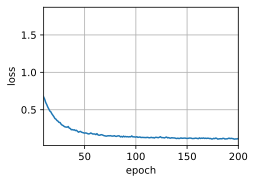

In [32]:
lr, num_epochs, device = 0.005, 200, try_gpu()
transformer_train_state = train_seq2seq(train_iter, lr, num_epochs, tgt_vocab)

# Evaluation

In [37]:
@jax.jit
def eval_encoder(state, enc_X, enc_valid_len):
    return Transformer().apply(
        {"params": state.params}, enc_X, enc_valid_len, train=False, method=EncoderDecoder.encode
    )


@jax.jit
def eval_decoder(state, dec_X, dec_state):
    return Transformer().apply({"params": state.params}, dec_X, dec_state, train=False, method=EncoderDecoder.decode)


def predict_seq2seq(state, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
    """Predict for sequence to sequence."""

    src_tokens = src_vocab[src_sentence.lower().split(" ")] + [src_vocab["<eos>"]]
    enc_valid_len = jnp.array([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab["<pad>"])

    # Add the batch axis
    enc_X = jnp.expand_dims(jnp.array(src_tokens, dtype=jnp.int64), axis=0)
    enc_outputs, encoder_attention_weights = eval_encoder(state, enc_X, enc_valid_len)
    dec_state = Transformer().decoder.init_state(enc_outputs, enc_valid_len)

    # Add the batch axis
    dec_X = jnp.expand_dims(jnp.array([tgt_vocab["<bos>"]], dtype=jnp.int64), axis=0)

    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state, decoder_attention_weights = eval_decoder(state, dec_X, dec_state)

        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(axis=2)

        pred = dec_X.squeeze(axis=0)

        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(decoder_attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred.item() == tgt_vocab["<eos>"]:
            break
        output_seq.append(int(pred.item()))

    return " ".join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq, encoder_attention_weights

In [40]:
import math
import collections

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU score up to k-grams between a predicted sequence and a reference."""
    # 1. Tokenize the two sentences on spaces
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)

    # 2. Brevity penalty: penalize very short predictions
    #    BP = exp(min(0, 1 – |ref|/|hyp|))
    #    if |hyp| < |ref|, term < 1; else BP = 1
    score = math.exp(min(0, 1 - len_label / len_pred))

    # 3. For each n from 1 to k, compute clipped n-gram precision and weight it
    for n in range(1, k + 1):
        num_matches = 0
        # Build a histogram of all n-grams in the reference
        label_subs = collections.defaultdict(int)
        for i in range(len_label - n + 1):
            # Concatenate tokens [i:i+n] into a single string key
            gram = "".join(label_tokens[i : i + n])
            label_subs[gram] += 1

        # Now count how many of the predicted n-grams appear in that histogram
        for i in range(len_pred - n + 1):
            gram = "".join(pred_tokens[i : i + n])
            if label_subs[gram] > 0:
                num_matches     += 1
                label_subs[gram] -= 1  # clip: don’t count this n-gram more than it appears

        # Precision = (# matched n-grams) / (# predicted n-grams)
        if len_pred - n + 1 > 0:
            precision_n = num_matches / (len_pred - n + 1)
        else:
            precision_n = 0.0

        # Weight this precision by 2^(–n) (i.e. geometric averaging with decreasing weights)
        score *= math.pow(precision_n, math.pow(0.5, n))

    return score

In [42]:
# 1. Example test pairs: English sentences and their French references
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]

# 2. Iterate over each English–French pair
for eng, fra in zip(engs, fras):
    # 3. Call your seq2seq model’s prediction function:
    #  It returns:
    #    * translation:                the model’s output sentence (string)
    #    * dec_attention_weight_seq:   a sequence of decoder attention weight matrices
    #    * encoder_attention_weights:  the encoder’s self-attention weights
    translation, dec_attention_weight_seq, encoder_attention_weights = predict_seq2seq(
        transformer_train_state,
        eng,
        src_vocab,
        tgt_vocab,
        num_steps,
        True
    )

    # 4. Compute a 2-gram BLEU score against the reference and print it
    #    - bleu(..., k=2) computes up to bigram precision + brevity penalty
    print(
        f"{eng} => {translation}, ",
        f"bleu {bleu(translation, fra, k=2):.3f}"
    )


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


# Visualization of attention heatmaps

We visualize the attention heatmaps for the last (english, french) pair, where the input has length 3 and the output has length 5.

The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).


In [43]:
enc_attention_weights = jnp.concatenate(encoder_attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

(2, 4, 10, 10)

Encoder self-attention for each of the 2 encoder blocks.
The input has length 4, so all keys are 0 after that.

In [44]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
    display.set_matplotlib_formats("svg")
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

/tmp/ipython-input-44-637965182.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


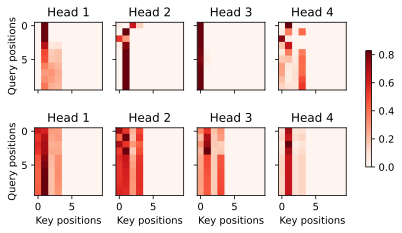

In [45]:
show_heatmaps(
    enc_attention_weights,
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

Next we visualize decoder attention heatmaps.

In [46]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk
]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

Decoder self-attention.

/tmp/ipython-input-44-637965182.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


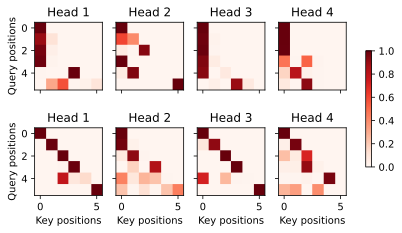

In [47]:
# Plus one to include the beginning-of-sequence token
show_heatmaps(
    dec_self_attention_weights[:, :, :, : len(translation.split()) + 1],
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

Decoder encoder-attention.

/tmp/ipython-input-44-637965182.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


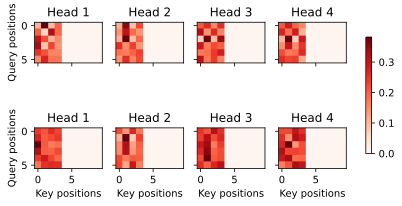

In [48]:
show_heatmaps(
    dec_inter_attention_weights,
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)